# Phi->ee predictions

The number of events can be found as:

$$N_{ev} = L_{int}\times \sigma_{coh}^{\phi(1020)} \times Acceptance \times BR \times \epsilon$$

For the `branching ratio`:

$$BR(\phi(1020)) = 2.97 \times 10^{-4} \text{ (electrons), }  0.492 \text{ (kaons) }$$




### Fiducial cross section

For the `fiducial cross section`:

$$\sigma_{fiducial} = \sigma_{coh}^{\phi(1020)} \times Acceptance$$

This can be obtained from STARlight as:

$$\sigma_{fiducial} = \sigma_{coh, SL}^{\phi(1020)} \times \frac{N_{after}}{N_{generated}}$$

where $\sigma_{coh, SL}^{\phi(1020)}$ is computed by running STARlight and the events are those that survive the $\eta$ cuts


### Efficiency

The efficiency can be thought as the product:

$$\epsilon = \epsilon_{detector} \times \epsilon_{trigger}$$

where $\epsilon_{detector}$ includes the `tracking efficiency`and the `PID efficiency`. Considering the continuous readout, it is not absurd to consider $$\epsilon_{trigger} = 1$$ in first approximation, although a more careful estimate might require considerations over the efficiency of the software filter. Thus:

$$\epsilon \approx \epsilon_{tracking}^2 \times \epsilon_{PID}^2$$

where the squared is due to having to do it for both tracks. We need to do this more complicate exercise since we cannot use ALICE Simulations.




#### Efficiency scenarios

Three are the scenarios we need to consider:
- 2 electrons in TPC, 0 in TOF
- 1 electrons in TPC, 1 in TOF
- 0 electrons in TPC, 2 in TOF

On top of this, we also need to consider the TPC-TOF matching efficiency:
- Low (< 50%) for $p_T < 0.3 GeV$
- Mid (50 to 70%) for $0.3 < p_T < 1 GeV$
- High (above 80%) for $p_T > 1 GeV$

$$\epsilon \approx \epsilon_{tracking}^2 \times \epsilon_{PID}^2 \times \epsilon_{TPC-TOF}^i$$

where the $i$ is because we need to consider it depending on the scenario we are in.


### Combining the scenarios

- Scenario A: Both tracks stay in the TPC (no TOF).
- Scenario B: One track reaches the TOF.
- Scenario C: Both tracks reach the TOF.

They are mutually exclusive: $P(A) + P(B) + P(C) = 1$

Thus, the real efficiency will be:

$$ \epsilon = P(A)\times \epsilon_A + P(B)\times \epsilon_B + P(C)\times \epsilon_C$$

In [1]:
import numpy as np

# Efficiency parametrizations
def tracking_efficiency(pt, eta):
    return 0.9  # Approximate tracking efficiency in TPC

def pid_efficiency_tpc():
    return 0.7  # PID efficiency using TPC only

def pid_efficiency_tof():
    return 0.9  # PID efficiency using TOF

def matching_efficiency(pt):
    """Approximate TPC-TOF matching efficiency as a function of pt."""
    if pt < 0.3:
        return 0.  # Low matching efficiency at low pt
    elif pt < 0.4:
        return 0.15  # Moderate matching efficiency
    elif pt < 0.5:
        return 0.3  # Moderate matching efficiency
    elif pt < 0.6:
        return 0.4  # Moderate matching efficiency
    elif pt < 1.0:
        return 0.5  # Moderate matching efficiency
    else:
        return 0.6  # High matching efficiency at high pt

# Compute single-event efficiency based on scenario
def compute_event_efficiency(scenario, pt1, pt2):
    # Track 1
    track_eff1 = tracking_efficiency(pt1, 0)
    if scenario == "A":
        pid_eff1 = pid_efficiency_tpc()
        match_eff1 = 1.0  # No TOF required
    else:
        pid_eff1 = pid_efficiency_tof() if scenario == "C" else pid_efficiency_tof()
        match_eff1 = matching_efficiency(pt1)

    # Track 2
    track_eff2 = tracking_efficiency(pt2, 0)
    if scenario == "A":
        pid_eff2 = pid_efficiency_tpc()
        match_eff2 = 1.0  # No TOF required
    else:
        pid_eff2 = pid_efficiency_tof() if scenario == "C" else pid_efficiency_tpc()
        match_eff2 = matching_efficiency(pt2) if scenario != "A" else 1.0

    # Combine efficiencies
    total_efficiency = (track_eff1 * pid_eff1 * match_eff1) * (track_eff2 * pid_eff2 * match_eff2)
    return total_efficiency

# Simulate events to compute probabilities and total efficiency
def simulate_scenarios(n_events=100000):
    scenario_counts = {"A": 0, "B": 0, "C": 0}
    scenario_efficiencies = {"A": 0, "B": 0, "C": 0}

    for _ in range(n_events):
        # Randomly assign track kinematics
        pt1, pt2 = np.random.normal(0.45, 0.1, 2)  # Example pT range in GeV
        eta1, eta2 = np.random.uniform(-0.8, 0.8, 2)  # Example eta range

        # Determine which tracks reach TOF
        tof1 = pt1 > 0.5  # Simplified TOF condition
        tof2 = pt2 > 0.5

        # Classify scenario
        if not tof1 and not tof2:
            scenario = "A"
        elif tof1 != tof2:
            scenario = "B"
        else:
            scenario = "C"

        # Increment scenario count
        scenario_counts[scenario] += 1

        # Compute event efficiency for the scenario
        event_efficiency = compute_event_efficiency(scenario, pt1, pt2)
        scenario_efficiencies[scenario] += event_efficiency

    # Compute probabilities and normalized efficiencies
    total_events = sum(scenario_counts.values())
    probabilities = {key: count / total_events for key, count in scenario_counts.items()}
    average_efficiencies = {
        key: scenario_efficiencies[key] / scenario_counts[key] if scenario_counts[key] > 0 else 0
        for key in scenario_counts
    }

    # Total weighted efficiency
    total_efficiency = sum(probabilities[scenario] * average_efficiencies[scenario] for scenario in probabilities)

    return probabilities, average_efficiencies, total_efficiency

# Run the simulation
probabilities, average_efficiencies, total_efficiency = simulate_scenarios()

# Print results
print("Scenario Probabilities:", probabilities)
print("Average Efficiencies:", average_efficiencies)
print(f"Total Efficiency: {total_efficiency:.2%}")


Scenario Probabilities: {'A': 0.47839, 'B': 0.42642, 'C': 0.09519}
Average Efficiencies: {'A': 0.3968999999998071, 'B': 0.0470620172013468, 'C': 0.1166588395839833}
Total Efficiency: 22.10%


# STARlight parser

In [2]:
import pandas as pd

def parse_starlight_output(file_path):
    events = []
    vertices = []
    tracks = []
    
    with open(file_path, 'r') as file:
        current_event = None
        current_vertex = None
        
        for line in file:
            if line.startswith("EVENT"):
                if current_event:
                    events.append(current_event)
                event_data = line.split()
                current_event = {
                    "Event Number": int(event_data[1]),
                    "Number of Tracks": int(event_data[2]),
                    "Number of Vertices": int(event_data[3]),
                    "Vertices": [],
                    "Tracks": []
                }
            elif line.startswith("VERTEX"):
                vertex_data = line.split()
                current_vertex = {
                    "x": float(vertex_data[1]),
                    "y": float(vertex_data[2]),
                    "z": float(vertex_data[3]),
                    "t": float(vertex_data[4]),
                    "Vertex Number": int(vertex_data[5]),
                    "Process Number": int(vertex_data[6]),
                    "Parent Track": int(vertex_data[7]),
                    "Number of Daughters": int(vertex_data[8])
                }
                current_event["Vertices"].append(current_vertex)
            elif line.startswith("TRACK"):
                track_data = line.split()
                track = {
                    "GPID": int(track_data[1]),
                    "px": float(track_data[2]),
                    "py": float(track_data[3]),
                    "pz": float(track_data[4]),
                    "Event Number": int(track_data[5]),
                    "Track Number": int(track_data[6]),
                    "Stop Vertex": int(track_data[7]),
                    "PDGPID": int(track_data[8])
                }
                current_event["Tracks"].append(track)
        
        if current_event:
            events.append(current_event)
    
    # Flatten the data into lists of dictionaries for DataFrame conversion
    event_list = []
    vertex_list = []
    track_list = []
    
    for event in events:
        event_list.append({
            "Event Number": event["Event Number"],
            "Number of Tracks": event["Number of Tracks"],
            "Number of Vertices": event["Number of Vertices"]
        })
        
        for vertex in event["Vertices"]:
            vertex["Event Number"] = event["Event Number"]
            vertex_list.append(vertex)
        
        for track in event["Tracks"]:
            track_list.append(track)
    
    # Convert to DataFrames
    event_df = pd.DataFrame(event_list)
    vertex_df = pd.DataFrame(vertex_list)
    track_df = pd.DataFrame(track_list)
    
    return event_df, vertex_df, track_df

# Example usage:
# event_df, vertex_df, track_df = parse_starlight_output('starlight_output.txt')

# Display the dataframes
# print(event_df.head())
# print(vertex_df.head())
# print(track_df.head())


In [3]:
import pandas as pd
import numpy as np
from scipy.constants import c
import vector


# Assuming the parse_starlight_output function from the previous code has been defined

def group_tracks_by_event(track_df):
    grouped_tracks = track_df.groupby('Event Number').apply(lambda x: x.to_dict(orient='records'), include_groups=False).to_dict()
    return grouped_tracks


def create_lorentz_vector(px, py, pz, mass):
    vec = vector.obj(px=px, py=py, pz=pz, E=(px**2 + py**2 + pz**2 + mass**2)**0.5)
    return vec


def get_mass_from_pdgid(pdgid):
    # This function would return the mass based on PDG ID
    # For simplicity, assuming some common particle masses
    pdg_masses = {
        11: 0.000511,  # Electron mass in GeV/c^2
        13: 0.10566,   # Muon mass in GeV/c^2
        211: 0.13957,  # Pion mass in GeV/c^2
        # Add more particles as needed
    }
    return pdg_masses.get(abs(pdgid), 0)  # Default to 0 if mass is unknown


def perform_operations_on_event(grouped_tracks):
    """
    Creates a DataFrame with all Lorentz vectors for each event using the vector package.

    Parameters:
    grouped_tracks (dict): A dictionary where keys are event numbers and values are lists of track dictionaries.

    Returns:
    DataFrame: A DataFrame with columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    daughters_list = []
    mothers_list = []

    for event_number, event_tracks in grouped_tracks.items():
        mother = create_lorentz_vector(0., 0., 0., 0.)
        for track in event_tracks:
            mass = get_mass_from_pdgid(track['PDGPID'])
            vec = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
            daughters_list.append({
                'Event Number': event_number,
                'Track Number': track['Track Number'],
                'Energy': vec.E,
                'px': vec.px,
                'py': vec.py,
                'pz': vec.pz
            })
            mother += vec
        mothers_list.append({
            'mother': mother,
            'Energy': mother.E,
            'px': mother.px,
            'py': mother.py,
            'pz': mother.pz
        })

    # Create DataFrame
    daughters_df = pd.DataFrame(daughters_list)
    mothers_df = pd.DataFrame(mothers_list)

    return daughters_df, mothers_df


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mass_and_pt_distribution(df):
    """
    Plots the mass distribution and transverse momentum distribution from a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    """

    # Calculate the mass and transverse momentum (p_T) for each row
    df['mass'] = df['mother'].apply(lambda v: v.mass)
    df['pt'] = df['mother'].apply(lambda v: v.pt)

    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the mass distribution
    ax[0].hist(df['mass'], bins=50, color='blue', alpha=0.7)
    ax[0].set_title('Mass Distribution')
    ax[0].set_xlabel('Mass (GeV/c^2)')
    ax[0].set_ylabel('Frequency')

    # Plot the transverse momentum distribution
    ax[1].hist(df['pt'], bins=50, color='green', alpha=0.7)
    ax[1].set_title('Transverse Momentum Distribution')
    ax[1].set_xlabel('p_T (GeV/c)')
    ax[1].set_ylabel('Frequency')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()



In [5]:
event_df, vertex_df, track_df = parse_starlight_output('slight-phi-ee-100k-no-eta-cut.out')
grouped_tracks = group_tracks_by_event(track_df)
daughters_df, phi_df = perform_operations_on_event(grouped_tracks)
phi_df.head()


,mother,Energy,px,py,pz
0,"MomentumObject4D(px=-0.021578933977835002, py=...",2.965424,-0.021579,0.012577,-2.784977
1,"MomentumObject4D(px=0.022421962771892002, py=0...",1.360240,0.022422,0.022489,-0.893628
2,"MomentumObject4D(px=-0.0053010746241339834, py...",1.195300,-0.005301,-0.051389,0.623971
3,"MomentumObject4D(px=-0.057914721934941, py=0.0...",4.230375,-0.057915,0.032171,4.105602
4,"MomentumObject4D(px=0.062369170993478995, py=0...",19.795684,0.062369,0.008935,19.769177


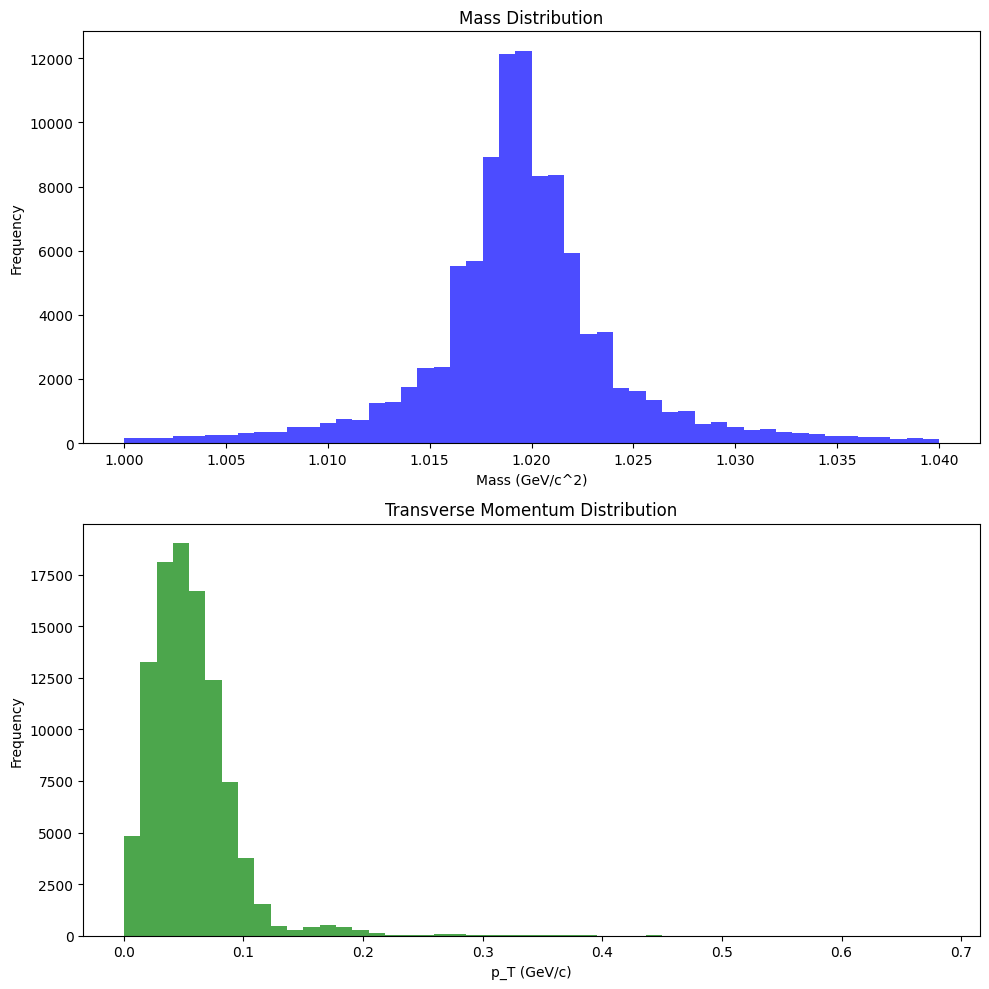

In [6]:
plot_mass_and_pt_distribution(phi_df)

In [7]:
daughters_df.head()

,Event Number,Track Number,Energy,px,py,pz
0,1,0,2.210161,-0.127849,0.429507,-2.164253
1,1,1,0.755263,0.106270,-0.416930,-0.620724
2,2,0,0.237614,-0.016749,0.066707,0.227442
3,2,1,1.122626,0.039171,-0.044219,-1.121070
4,3,0,0.430432,0.349350,-0.250314,-0.023851


#### Computing fiducial cross sections

In [8]:
# Calculate rapidity y = 0.5 * ln((E + pz) / (E - pz)) for each track
daughters_df['Rapidity'] = 0.5 * np.log((daughters_df['Energy'] + daughters_df['pz']) /
                                        (daughters_df['Energy'] - daughters_df['pz']))
daughters_df.head()

,Event Number,Track Number,Energy,px,py,pz,Rapidity
0,1,0,2.210161,-0.127849,0.429507,-2.164253,-2.278441
1,1,1,0.755263,0.106270,-0.416930,-0.620724,-1.162536
2,2,0,0.237614,-0.016749,0.066707,0.227442,1.911250
3,2,1,1.122626,0.039171,-0.044219,-1.121070,-3.637069
4,3,0,0.430432,0.349350,-0.250314,-0.023851,-0.055469


In [10]:
# Step 1: Filter out tracks with |rapidity| > 0.8
filtered_df = daughters_df[abs(daughters_df['Rapidity']) <= 0.8]

# Step 2: Define a function to count instances where the same event number appears twice
def count_dropped_events(original_df, filtered_df):
    # Get the event counts in the original dataframe
    original_event_counts = original_df['Event Number'].value_counts()
    # Get the event counts in the filtered dataframe
    filtered_event_counts = filtered_df['Event Number'].value_counts()
    # Count events that had at least 2 tracks in the original dataframe but no longer satisfy this condition
    dropped_events = sum((original_event_counts >= 2) & (filtered_event_counts < 2))
    original_events = sum(original_event_counts >= 2)
    return dropped_events, original_events

# Count dropped events
dropped_events_count, original_events_count = count_dropped_events(daughters_df, filtered_df)
dropped_events_count
# original_events_count


28422

In [11]:
original_events_count

100000

In [12]:
filtered_df.head()

,Event Number,Track Number,Energy,px,py,pz,Rapidity
4,3,0,0.430432,0.349350,-0.250314,-0.023851,-0.055469
15,8,1,0.583412,-0.505052,-0.067015,-0.284254,-0.532417
16,9,0,0.396543,0.372348,-0.094236,-0.098602,-0.253977
18,10,0,0.552447,-0.467400,-0.107681,0.274115,0.544230
19,10,1,0.603244,0.515794,0.170678,0.262160,0.465535


In [13]:
filtered_df

,Event Number,Track Number,Energy,px,py,pz,Rapidity
4,3,0,0.430432,0.349350,-0.250314,-0.023851,-0.055469
15,8,1,0.583412,-0.505052,-0.067015,-0.284254,-0.532417
16,9,0,0.396543,0.372348,-0.094236,-0.098602,-0.253977
18,10,0,0.552447,-0.467400,-0.107681,0.274115,0.544230
19,10,1,0.603244,0.515794,0.170678,0.262160,0.465535
...,...,...,...,...,...,...,...
199980,99991,0,0.171094,0.074709,0.140764,0.062266,0.381408
199982,99992,0,0.454731,0.365929,-0.177772,0.203159,0.480653
199987,99994,1,0.523264,-0.338359,0.218567,0.333986,0.755255
199989,99995,1,0.422515,0.420124,-0.009044,-0.043958,-0.104418


In [14]:
xsec_sl = 98.431 #microbarn
fiducial_xsec = xsec_sl * (original_events_count - dropped_events_count) / original_events_count
fiducial_xsec

70.45494117999999

### Predictions for ALICE

Note: the xsec from STARlight is `98.431 microbarn` for $\phi\rightarrow ee$

Note: the xsec from STARlight is `161.900 mb` for $\phi\rightarrow KK$

Is it the real cross section or the cross section for the decay with the BR included?

Seems so, since if I take the cross section and divide it for the ratio of the BRs I get the first one...

In [18]:
lumi = 236 #microbarns
BR = 0.000297
N = fiducial_xsec * total_efficiency * lumi * BR
N

1.0915972538050744

In [24]:
# Run 3 + Run 4
lumi = 10000 #microbarns
BR = 0.000297
N = fiducial_xsec * total_efficiency * lumi * BR
N

46.25412092394384

In [25]:
# Assuming it already contains the BR
lumi = 236 #microbarns
N = fiducial_xsec * total_efficiency * lumi 
N

3675.4116289733147